In [255]:
import os
import pdb
import pickle
import random
import numpy as np

import torch

import matplotlib
import matplotlib.pyplot as plt

Define visualization function

In [256]:

def plot_data_and_label(ax, data_all, label_all, domain=False):
    # data_all = (data_all - data_all.mean(0, keepdims=True)) / data_all.std(0, keepdims=True)

    cmap = matplotlib.cm.get_cmap('rainbow')
    num = int(np.max(label_all)) + 1
    l_color = [cmap(ele)[:3] for ele in np.linspace(0, 1, num)]

    for i in range(num):
        data_sub = data_all[label_all == i, :]
        # data_sub = data_all
        if domain:
            ax.plot(data_sub[:, 0], data_sub[:, 1], '.', color=l_color[i % len(l_color)])
        else:
            ax.plot(data_sub[:, 0], data_sub[:, 1], ['x', '.'][i], color=['b', 'r'][i], alpha=0.5)


def plot_dataset(info):
    asp = 0.75
    fig, ax = plt.subplots(1, 2, figsize=(6 * 2, 6 * asp))
    data = info['data']
    label = info['label']
    domain = info['domain']
    plot_data_and_label(ax[0], data, domain, True)
    plot_data_and_label(ax[1], data, label, False)
    ax[0].set_title('Color encodes domain', fontsize=15)
    ax[1].set_title('Color encodes label', fontsize=15)
    plt.tight_layout(pad=0)
    plt.show()

Define load data function

In [257]:
def load_pkl(data_path):
    if os.path.exists(data_path):
        print("load cache from {}...".format(data_path))
        with open(data_path, "rb") as fin:
            data_pkl = pickle.load(fin)
    else:
        raise NotImplementedError
    return data_pkl

In [258]:
data_name = "Circle"
data_path = '/data/qtx/DataSets/Toy_Circle/half-circle.pkl'

load cache from /data/qtx/DataSets/Toy_Circle/half-circle.pkl...
dict_keys(['data', 'label', 'domain'])
(3000, 2) (3000,) (3000,)


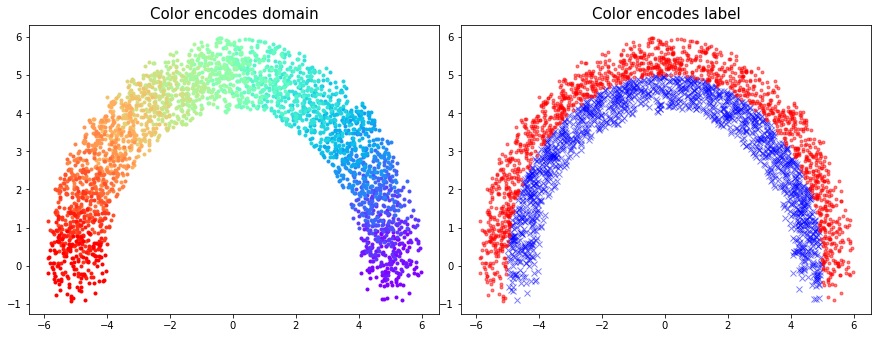

In [259]:
data_pkl = load_pkl(data_path)
print(data_pkl.keys())
print(data_pkl['data'].shape, data_pkl['label'].shape, data_pkl['domain'].shape)

plot_dataset(data_pkl)

### 1.Define autoencoder components

In [260]:
# Hyperparameters

# dataset
data_name = "Circle"
data_path = '/data/qtx/DataSets/Toy_Circle/half-circle.pkl'
num_classes = 2
data_size = [1, 2]
source_domains = 15
intermediate_domains = 5
target_domains = 10

# dataloader
train_batch_size = 24
eval_batch_size = 50
num_workers = 4

# autoencoder
feature_dim = 512
zc_dim = 20
zw_dim = 20
zv_dim = num_classes
stochastic=True

# optimization
epochs = 50
iterations = 200
lr = 5e-5
weight_decay = 0.

seed = 0

In [261]:
random.seed(seed)
np.random.seed(seed)
torch.random.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Define dataset

In [262]:
from torch.utils.data import TensorDataset

class MultipleEnvironmentCircle(object):
    def __init__(self, root, environments, dataset_transform, input_shape, num_classes):
        super(MultipleEnvironmentCircle, self).__init__()
        self.Environments = environments
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.normalize = False  # Don't do normalization for DG

        if root is None:
            raise ValueError('Data directory not specified!')

        self.data_pkl = load_pkl(root)

        if self.normalize:
            data = self.data_pkl['data']
            data_mean = data.mean(0, keepdims=True)
            data_std = data.std(0, keepdims=True)
            self.data_pkl['data'] = (data - data_mean) / data_std  # normalize the raw data

        self.datasets = []
        for domain_id in range(len(environments)):
            idx = self.data_pkl['domain'] == domain_id
            data = self.data_pkl['data'][idx].astype(np.float32)
            labels = self.data_pkl['label'][idx].astype(np.int64)

            self.datasets.append(dataset_transform(data, labels))

    def __getitem__(self, index):
        return self.datasets[index]

    def __len__(self):
        return len(self.datasets)

class ToyCircle(MultipleEnvironmentCircle):
    """
    source domains: 0~14
    intermedia domains: 15~19
    target domains: 20~29
    """
    def __init__(self, root, input_shape, num_classes):
        num_domains = 30
        environments = list(np.arange(num_domains))
        self.normalize_domain = False
        super(ToyCircle, self).__init__(root, environments, self.process_dataset, input_shape, num_classes)

    def process_dataset(self, data, labels):
        x = torch.tensor(data).float()
        y = torch.tensor(labels).long()
        if self.normalize_domain:
            mu, sigma = x.mean(0, keepdims=True), x.std(0, keepdims=True)
            x = (x - mu) / sigma
        return TensorDataset(x, y)

Define dataloader

In [263]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
class _InfiniteSampler(torch.utils.data.Sampler):
    """Wraps another Sampler to yield an infinite stream."""

    def __init__(self, sampler):
        self.sampler = sampler

    def __iter__(self):
        while True:
            for batch in self.sampler:
                yield batch


class InfiniteDataLoader:
    def __init__(self, dataset, weights, batch_size, num_workers):
        super().__init__()

        if weights is not None:
            sampler = torch.utils.data.WeightedRandomSampler(weights,
                                                             replacement=True,
                                                             num_samples=batch_size)
        else:
            sampler = torch.utils.data.RandomSampler(dataset,
                                                     replacement=True)

        if weights == None:
            weights = torch.ones(len(dataset))

        batch_sampler = torch.utils.data.BatchSampler(
            sampler,
            batch_size=batch_size,
            drop_last=True)

        self._infinite_iterator = iter(torch.utils.data.DataLoader(
            dataset,
            num_workers=num_workers,
            batch_sampler=_InfiniteSampler(batch_sampler)
        ))

    def __iter__(self):
        while True:
            yield next(self._infinite_iterator)

    def __len__(self):
        raise ValueError


class FastDataLoader:
    """DataLoader wrapper with slightly improved speed by not respawning worker
    processes at every epoch."""

    def __init__(self, dataset, batch_size, num_workers):
        super().__init__()

        batch_sampler = torch.utils.data.BatchSampler(
            torch.utils.data.RandomSampler(dataset, replacement=False),
            batch_size=batch_size,
            drop_last=False
        )

        self._infinite_iterator = iter(torch.utils.data.DataLoader(
            dataset,
            num_workers=num_workers,
            batch_sampler=_InfiniteSampler(batch_sampler)
        ))

        self._length = len(batch_sampler)

    def __iter__(self):
        for _ in range(len(self)):
            yield next(self._infinite_iterator)

    def __len__(self):
        return self._length

Define func for data split

In [264]:
import copy
from sklearn.model_selection import train_test_split

def split_train_test_datasets(all_dataset, train_size=0.5, val_size=0., test_size=0.5):
    num_datasets = len(all_dataset)
    domain_idx = np.arange(num_datasets)
    train_domain_idx, test_domain_idx = train_test_split(domain_idx, train_size=train_size,
                                                         test_size=(val_size + test_size), shuffle=False)
    val_domain_idx, test_domain_idx = train_test_split(test_domain_idx, train_size=val_size, test_size=test_size,
                                                       shuffle=False)

    train_datasets = copy.deepcopy(all_dataset)
    train_datasets.datasets = train_datasets.datasets[train_domain_idx[0]:train_domain_idx[-1] + 1]
    train_datasets.Environments = train_datasets.Environments[train_domain_idx[0]:train_domain_idx[-1] + 1]

    val_datasets = copy.deepcopy(all_dataset)
    val_datasets.datasets = val_datasets.datasets[val_domain_idx[0]:val_domain_idx[-1] + 1]
    val_datasets.Environments = val_datasets.Environments[val_domain_idx[0]:val_domain_idx[-1] + 1]

    test_datasets = copy.deepcopy(all_dataset)
    test_datasets.datasets = test_datasets.datasets[test_domain_idx[0]:test_domain_idx[-1] + 1]
    test_datasets.Environments = test_datasets.Environments[test_domain_idx[0]:test_domain_idx[-1] + 1]

    return train_datasets, val_datasets, test_datasets

def one_hot(indices, depth, device=None):
    """
    Returns a one-hot tensor.
    This is a PyTorch equivalent of Tensorflow's tf.one_hot.
    Parameters:
      indices:  a (n_batch, m) Tensor or (m) Tensor.
      depth: a scalar. Represents the depth of the one hot dimension.
    Returns: a (n_batch, m, depth) Tensor or (m, depth) Tensor.
    """
    if device is None:
        encoded_indicies = torch.zeros(indices.size() + torch.Size([depth]))
    else:
        encoded_indicies = torch.zeros(indices.size() + torch.Size([depth])).to(device)

    index = indices.view(indices.size() + torch.Size([1]))
    encoded_indicies = encoded_indicies.scatter_(1, index, 1)

    return encoded_indicies

Package dataloader into iterator

In [265]:
circle_dataset = ToyCircle(data_path, data_size, num_classes)
source_datasets, intermediate_datasets, target_datasets = split_train_test_datasets(circle_dataset,
                                                                                      source_domains,
                                                                                      intermediate_domains,
                                                                                      target_domains)
train_loaders = [InfiniteDataLoader(
    dataset=env,
    weights=None,
    batch_size=train_batch_size,
    num_workers=num_workers)
    for i, env in enumerate(source_datasets.datasets)]

val_loaders = [FastDataLoader(
    dataset=env,
    batch_size=eval_batch_size,
    num_workers=num_workers)
    for env in intermediate_datasets.datasets]

test_loaders = [FastDataLoader(
    dataset=env,
    batch_size=eval_batch_size,
    num_workers=num_workers)
    for env in target_datasets.datasets]


val_loader_names = ['Env:{}'.format(i) for i in intermediate_datasets.Environments]
val_domain_idxes = [domain_idx for domain_idx in range(source_domains, source_domains +
                                                       intermediate_domains)]
test_loader_names = ['Env:{}'.format(i) for i in target_datasets.Environments]
test_domain_idxes = [domain_idx for domain_idx in range(source_domains + intermediate_domains,
                                                        source_domains + intermediate_domains + target_domains)]

train_minibatches_iterator = zip(*train_loaders)
val_minibatches_iterator = tuple(zip(val_loader_names, val_domain_idxes, val_loaders))
test_minibatches_iterator = tuple(zip(test_loader_names, test_domain_idxes, test_loaders))

load cache from /data/qtx/DataSets/Toy_Circle/half-circle.pkl...


---
### 2.Define autoencoder components

In [266]:
# model components

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class LinearFeatExtractor(nn.Module):
    """Just  an MLP"""
    def __init__(self, input_shape, output_dim, hidden_dim=512, depth=4, drop_rate=0.):
        super(LinearFeatExtractor, self).__init__()
        self.input = nn.Linear(input_shape[-1], hidden_dim)
        self.dropout = nn.Dropout(drop_rate)
        self.hiddens = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim)
            for _ in range(depth - 2)])
        self.output = nn.Linear(hidden_dim, output_dim)
        self.n_outputs = output_dim

    def forward(self, x):
        x = self.input(x)
        x = self.dropout(x)
        x = F.relu(x)
        for hidden in self.hiddens:
            x = hidden(x)
            x = self.dropout(x)
            x = F.relu(x)
        x = self.output(x)
        return x


class SingleLayerClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SingleLayerClassifier, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x.view(x.size(0), -1))
        return out

Define components for autoencoder

In [267]:
from abc import abstractmethod

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.distributions import Normal, Independent
import network.init_func as init


# ======================== Modules for AutoEncoder=======================================================
class ProbabilisticModel(nn.Module):
    def __init__(self, latent_dim, stochastic):
        super(ProbabilisticModel, self).__init__()
        self.latent_dim = latent_dim
        self.stochastic = stochastic
        self.latent_space = None
        self.gaussian_module = AxisAlignedConvGaussian(latent_dim)

    @abstractmethod
    def forward(self, x, *args, **kwargs):
        pass

    def sampling(self, batch_size=1):
        if self.training:
            latent_value = self.latent_space.rsample((batch_size, ))
        else:
            latent_value = self.latent_space.sample((batch_size, ))
        # latent_value = self.latent_space.sample()
        if batch_size == 1:
            latent_value = latent_value.squeeze(0)
        return latent_value


class AxisAlignedConvGaussian(nn.Module):
    def __init__(self, latent_dim):
        super(AxisAlignedConvGaussian, self).__init__()
        self.latent_dim = latent_dim

    def forward(self, mu_log_sigma):
        mu = mu_log_sigma[:, :self.latent_dim]
        log_sigma = mu_log_sigma[:, self.latent_dim:]
        dist = Independent(Normal(loc=mu, scale=torch.exp(log_sigma), validate_args=False), 1)
        return dist


class GaussianModule(ProbabilisticModel):
    def __init__(self, latent_dim, stochastic=True):
        super(GaussianModule, self).__init__(latent_dim, stochastic)
        self.default_batch_size = 1
        self._build()

    def _build(self):
        self.dummy_param = nn.Parameter(torch.empty(0))
        standard_latent_input = torch.zeros([self.default_batch_size, 2 * self.latent_dim]).cuda()
        self.latent_space = self.gaussian_module(standard_latent_input)

    def sampling_by_mu_sigma(self, mu_log_sigma, batch_size=1):
        latent_space = self.gaussian_module(mu_log_sigma)
        latent_value = latent_space.sample((batch_size,)).squeeze(1)
        return latent_value


class LinearAffineModule(nn.Module):
    def __init__(self, input_dim, output_dim, batchnorm=True, nonlinearity=nn.LeakyReLU(0.02)):
        super(LinearAffineModule, self).__init__()
        if batchnorm is True:
            self.model = nn.Sequential(
                    nn.Linear(input_dim, output_dim),
                    nn.BatchNorm1d(output_dim), nonlinearity)
        else:
            self.model = nn.Sequential(
                    nn.Linear(input_dim, output_dim), nonlinearity)

    def forward(self, x):
        return self.model(x)


class LinearDecoder(nn.Module):
    """
    Adjust from: https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan_gp/wgan_gp.py
    """
    def __init__(self, latent_dim, output_shape):
        super(LinearDecoder, self).__init__()

        self.output_shape = output_shape

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 16, normalize=False),
            *block(16, 64),
            *block(64, 128),
            nn.Linear(128, int(np.prod(output_shape))),
            # nn.Sigmoid()
        )

    def forward(self, latent_variables):
        img = self.model(latent_variables)
        img = img.view(img.shape[0], -1)
        return img

# ==================== Modules for Covariant shift =================================
class ProbabilisticSingleLayerLSTM(ProbabilisticModel):
    def __init__(self, input_dim, hidden_dim, stochastic=True):
        super(ProbabilisticSingleLayerLSTM, self).__init__(input_dim, stochastic)
        self.cur_input_dim = 2 * input_dim if stochastic else input_dim
        self.lstm = nn.LSTMCell(self.cur_input_dim, hidden_dim)
        self.fc_affine_layer = nn.Linear(hidden_dim, self.cur_input_dim)
        self.register_buffer('h0', torch.zeros([1, self.cur_input_dim]))
        self.register_buffer('c0', torch.zeros([1, self.cur_input_dim]))

    def forward(self, z_t, hidden_state, cell_state):
        hidden_state, cell_state = self.lstm(z_t, (hidden_state, cell_state))
        latent_variables = self.fc_affine_layer(hidden_state)
        if self.stochastic:
            self.latent_space = self.gaussian_module(latent_variables)
        return latent_variables, hidden_state, cell_state


class StaticProbabilisticEncoder(ProbabilisticModel):
    def __init__(self, model_func, latent_dim, stochastic=True):
        super(StaticProbabilisticEncoder, self).__init__(latent_dim, stochastic)
        self.model_func = model_func
        self.zx_dim = 2 * latent_dim if stochastic else latent_dim
        self.conv_fc = nn.Sequential(LinearAffineModule(model_func.n_outputs, model_func.n_outputs))
        self.bi_lstm_layer = nn.LSTM(model_func.n_outputs, self.latent_dim, 1, bidirectional=True, batch_first=True)
        self.fc_affine_layer = LinearAffineModule(2 * latent_dim, self.zx_dim, batchnorm=False)

    def forward(self, x, *args, **kwargs):
        """
        :param x: [bz, d, c, h, w]
        :return:
        """
        batch_size, domains = x.shape[:2]
        x = x.contiguous().view(batch_size * domains, *x.shape[2:])
        encoding = self.conv_fc(self.model_func(x)).view(batch_size, domains, -1)
        lstm_out, _ = self.bi_lstm_layer(encoding)  # [bz, d, 2*latent_dim]
        # https://gist.github.com/ceshine/bed2dadca48fe4fe4b4600ccce2fd6e1
        # backward = lstm_out[:, 0, self.latent_dim:2 * self.latent_dim]
        # frontal = lstm_out[:, domains - 1, 0:self.latent_dim]

        frontal = lstm_out[:, :, 0:self.latent_dim]
        backward = lstm_out[:, :, self.latent_dim:]
        backward = torch.flip(backward, dims=[1])
        lstm_out = torch.cat((frontal, backward), dim=-1)
        lstm_out = lstm_out.view(batch_size*domains, -1)
        latent_variables = self.fc_affine_layer(lstm_out)
        if self.stochastic:
            self.latent_space = self.gaussian_module(latent_variables)

        return latent_variables


class DynamicProbabilisticEncoder(ProbabilisticModel):
    def __init__(self, model_func, latent_dim, env_latent_dim, factorised=True, stochastic=True):
        super(DynamicProbabilisticEncoder, self).__init__(latent_dim, stochastic)
        self.model_func = model_func
        self.factorised = factorised
        self.env_latent_dim = env_latent_dim
        self.zw_dim = 2 * latent_dim if stochastic else latent_dim
        self.conv_fc = nn.Sequential(LinearAffineModule(model_func.n_outputs, model_func.n_outputs))

        if factorised:
            self.z_linear = LinearAffineModule(model_func.n_outputs, self.zw_dim, batchnorm=False)
            # init.init_weights(self.z_linear, init_type=init_type)
        else:
            self.z_lstm = nn.LSTM(model_func.n_outputs, self.zw_dim, num_layers=1, bidirectional=False, batch_first=True)
            # self.z_lstm = nn.LSTM(model_func.n_outputs + env_latent_dim, latent_dim, 1, bidirectional=True, batch_first=True)
            # self.z_rnn = nn.RNN(latent_dim * 2, latent_dim * 2, batch_first=True)

        self.fc_affine_layer = nn.Linear(self.zw_dim, self.zw_dim)

    def forward(self, x, static_z=None):
        """
        :param x: [bz, d, c, h, w]
        :return:
        """
        batch_size, domains = x.shape[:2]
        x = x.contiguous().view(batch_size * domains, *x.shape[2:])
        encoding = self.conv_fc(self.model_func(x))

        if self.factorised:
            latent_variables = self.z_linear(encoding)  # [batch_size*domains, latent_dim]
        else:
            encoding = encoding.view(batch_size, domains, -1)  # [batch_size, domains, feature_dim]
            # # static_z = static_z.unsqueeze(1).expand(-1, domains, self.env_latent_dim)
            # static_z = static_z.view(batch_size, domains, -1)
            # lstm_out, _ = self.z_lstm(torch.cat([encoding, static_z], dim=-1))
            # latent_variables, _ = self.z_rnn(lstm_out)   # [batch_size, domains, latent_dim]
            latent_variables, _ = self.z_lstm(encoding)
            latent_variables = latent_variables.contiguous().view(batch_size * domains, -1)

        latent_variables = self.fc_affine_layer(latent_variables)

        if self.stochastic:
            self.latent_space = self.gaussian_module(latent_variables)

        latent_variables = latent_variables.view(batch_size, domains, -1)

        return latent_variables


# ==================== Modules for Concept shift =================================
class ProbabilisticCategoryModel(nn.Module):
    """
    Category distribution
    """
    def __init__(self, latent_dim, stochastic):
        super(ProbabilisticCategoryModel, self).__init__()
        self.latent_dim = latent_dim
        self.stochastic = stochastic
        self.gumbel_prior = None
        self.latent_space = None

    @abstractmethod
    def forward(self, x):
        pass

    def sampling(self, batch_size=1):
        # Gumbel-Softmax Trick, please refer to
        # https://pytorch.org/docs/stable/generated/torch.nn.functional.gumbel_softmax.html#torch.nn.functional.gumbel_softmax
        # https://github.com/shaabhishek/gumbel-softmax-pytorch/blob/master/Categorical%20VAE.ipynb
        # We want to generate the percentage of each category here, thus not using hard mode
        if self.training:
            latent_value = F.gumbel_softmax(self.gumbel_prior, tau=1., hard=False).unsqueeze(0)
            if batch_size == 1:
                latent_value = latent_value.squeeze(0)
        else:
            latent_value = self.latent_space.probs
            latent_value = latent_value.expand(batch_size, -1).unsqueeze(1)
        return latent_value


class ProbabilisticCatSingleLayer(ProbabilisticCategoryModel):
    """
    The module for  pzv
    """
    def __init__(self, input_dim, hidden_dim=64, stochastic=True):
        super(ProbabilisticCatSingleLayer, self).__init__(hidden_dim, stochastic)
        self.lstm = nn.LSTMCell(input_dim, hidden_dim)
        self.fc_affine_layer = nn.Linear(hidden_dim, input_dim)
        self.register_buffer('h0', torch.zeros([1, hidden_dim]))
        self.register_buffer('c0', torch.zeros([1, hidden_dim]))

    def forward(self, z_t, hidden_state, cell_state):
        hidden_state, cell_state = self.lstm(z_t, (hidden_state, cell_state))
        latent_variables = self.fc_affine_layer(hidden_state)
        if self.stochastic:
            self.gumbel_prior = latent_variables
            logits_z = F.log_softmax(latent_variables, dim=-1)
            self.latent_space = torch.distributions.Categorical(logits=logits_z, validate_args=False)
        return latent_variables, hidden_state, cell_state


class DynamicCatEncoder(ProbabilisticCategoryModel):
    """
    The module for qzv
    """
    def __init__(self, input_dim, env_latent_dim, hidden_dim=64, factorised=True, stochastic=True):
        super(DynamicCatEncoder, self).__init__(input_dim, stochastic)
        self.factorised = factorised
        self.env_latent_dim = env_latent_dim

        self.proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim*2),
            nn.BatchNorm1d(hidden_dim*2),
            nn.ReLU(),
            nn.Linear(hidden_dim*2, hidden_dim)
        )
        self.conv_fc = nn.Sequential(LinearAffineModule(hidden_dim, hidden_dim))

        if self.factorised:
            self.z_linear = LinearAffineModule(hidden_dim, input_dim, batchnorm=False)
        else:
            # self.z_lstm = nn.LSTM(hidden_dim + env_latent_dim, input_dim, 1, bidirectional=True, batch_first=True)
            # self.z_rnn = nn.RNN(input_dim*2, input_dim, batch_first=True)
            self.z_lstm = nn.LSTM(hidden_dim, input_dim, num_layers=1, bidirectional=False, batch_first=True)

        self.fc_affine_layer = nn.Linear(input_dim, input_dim)

    def forward(self, y, static_z=None):
        """
        :param y: [bz, d, class_num]
        :param static_z:
        :return:
        """
        batch_size, domains = y.shape[:2]
        y = y.contiguous().view(batch_size * domains, *y.shape[2:])
        encoding = self.conv_fc(self.proj(y))
        if self.factorised:
            latent_variables = self.z_linear(encoding)
        else:
            encoding = encoding.view(batch_size, domains, -1)  # [batch_size, domains, feature_dim]
            # static_z = static_z.view(batch_size, domains, -1)
            # # static_z = static_z.unsqueeze(1).expand(-1, domains, self.env_latent_dim)
            # lstm_out, _ = self.z_lstm(torch.cat([encoding, static_z], dim=-1)) # [48, 10, 20]
            # latent_variables, _ = self.z_rnn(lstm_out)   # [batch_size, domains, latent_dim]
            latent_variables, _ = self.z_lstm(encoding)  # [48, 10, 20]
            latent_variables = latent_variables.contiguous().view(batch_size * domains, -1)

        latent_variables = self.fc_affine_layer(latent_variables)

        if self.stochastic:
            self.gumbel_prior = latent_variables
            logits_z = F.log_softmax(latent_variables, dim=-1)
            self.latent_space = torch.distributions.Categorical(logits=logits_z, validate_args=False)

        latent_variables = latent_variables.view(batch_size, domains, -1)

        return latent_variables

In [268]:
class LSSAE(nn.Module):
    """
    Implementation of LSSAE.
    """
    def __init__(self, model_func, cla_func):
        super(LSSAE, self).__init__()
        self.model_func = model_func
        self.cla_func = cla_func
        self.stochastic = True
        self.factorised = True
        self.aux_loss_multiplier_y = 100
        self.ts_multiplier = 20

        self._build()

    def _build(self):
        # Static env components
        self.static_prior = GaussianModule(zc_dim)
        self.dynamic_w_prior = ProbabilisticSingleLayerLSTM(input_dim=zw_dim,
                                                            hidden_dim=2 * zw_dim,
                                                            stochastic=self.stochastic)

        self.dynamic_v_prior = ProbabilisticCatSingleLayer(input_dim=zv_dim,
                                                           hidden_dim=2 * zv_dim,
                                                           stochastic=self.stochastic)

        self.static_encoder = StaticProbabilisticEncoder(self.model_func, zc_dim,
                                                         stochastic=self.stochastic)
        self.dynamic_w_encoder = DynamicProbabilisticEncoder(copy.deepcopy(self.model_func),
                                                             zw_dim, zc_dim,
                                                             factorised=self.factorised,
                                                             stochastic=self.stochastic)
        self.dynamic_v_encoder = DynamicCatEncoder(zv_dim, zc_dim,
                                                   factorised=self.factorised,
                                                   stochastic=self.stochastic)

        self.decoder = LinearDecoder(zc_dim + zw_dim, data_size)

        self.category_cla_func = self.cla_func

        self.opt = torch.optim.Adam([{'params': self.static_encoder.parameters()},
                                     {'params': self.category_cla_func.parameters()},
                                     {'params': self.decoder.parameters()},
                                     {'params': self.dynamic_w_encoder.parameters(), 'lr': 0.1 * lr},
                                     {'params': self.dynamic_v_encoder.parameters(), 'lr': 0.1 * lr},
                                     {'params': self.dynamic_w_prior.parameters(), 'lr': 0.1 * lr},
                                     {'params': self.dynamic_v_prior.parameters(), 'lr': 0.1 * lr}],
                                    lr=lr, weight_decay=weight_decay)

        self.recon_criterion = nn.MSELoss(reduction='sum')
        self.criterion = nn.CrossEntropyLoss()

    def calc_recon_loss(self, recon_x, x):
        recon_loss = self.recon_criterion(recon_x, x)
        # recon_loss = torch.sum(torch.mean(recon_loss, dim=-1))
        recon_loss = recon_loss.sum()
        return recon_loss

    @staticmethod
    def calc_temporal_smooth_loss(latent_variables, batch_first=True):
        if batch_first:
            return F.l1_loss(latent_variables[:, 1:, :], latent_variables[:, :-1, :], reduction='mean')
        else:
            return F.l1_loss(latent_variables[1:, :, :], latent_variables[-1:, :, :], reduction='mean')

    @staticmethod
    def gen_dynamic_prior(prior_net, prior_latent_dim, domains, batch_size=1, stochastic=False):
        z_out, z_out_value = None, None
        hx = Variable(prior_net.h0.detach().clone(), requires_grad=True)
        cx = Variable(prior_net.c0.detach().clone(), requires_grad=True)

        init_prior = torch.zeros([2 * prior_latent_dim if stochastic else prior_latent_dim]).cuda()

        z_t = Variable(init_prior.detach().clone(), requires_grad=True).unsqueeze(0)

        for _ in range(domains):
            z_t, hx, cx = prior_net(z_t, hx, cx.detach().clone())

            if z_out is None:
                # If z_out is none it means z_t is z_1, hence store it in the format [batch_size, 1, z_dim]
                z_out = z_t.unsqueeze(1)
                z_out_value = prior_net.sampling(batch_size)
            else:
                z_out = torch.cat((z_out, z_t.unsqueeze(1)), dim=1)
                z_out_value = torch.cat((z_out_value, prior_net.sampling(batch_size)), dim=1)
        return z_out, z_out_value

    def update(self, minibatches, unlabeled=None):
        """
        :param minibatches: list
        :param unlabeled:
        :return:
        """
        all_x = torch.stack([x for x, y in minibatches])  # [source_domains, batch_size, data_size]
        all_y = torch.stack([y for x, y in minibatches])  # [source_domains, batch_size]

        domains, batch_size = all_x.shape[:2]

        all_x = torch.transpose(all_x, 0, 1)  # [batch_size, source_domains, data_size]
        all_y = torch.transpose(all_y, 0, 1)  # [batch_size, source_domains]

        # ------------------------------ Covariant shift  -------------------------------
        static_qx_latent_variables = self.static_encoder(all_x)  # [batch_size, zc_dim*2]
        dynamic_qw_latent_variables = self.dynamic_w_encoder(all_x, None)  # [batch_size, source_domains, zw_dim*2]
        dynamic_pw_latent_variables, _ = self.gen_dynamic_prior(self.dynamic_w_prior, zw_dim, domains, batch_size,
                                                                self.stochastic)  # [1, source_domains, zw_dim*2]

        zc = self.static_encoder.sampling()
        zw = self.dynamic_w_encoder.sampling()
        recon_x = self.decoder(torch.cat([zc, zw], dim=1))
        all_x = all_x.contiguous().view(batch_size * domains, *all_x.shape[2:])
        CE_x = self.calc_recon_loss(recon_x, all_x)

        # Distribution loss
        # kld on zc
        static_kld = -1.0 * torch.sum(1 + static_qx_latent_variables[:, zc_dim:] -
                                      torch.pow(static_qx_latent_variables[:, :zc_dim], 2) -
                                      torch.exp(static_qx_latent_variables[:, zc_dim:]))
        # kld on zw
        dynamic_qw_mu, dynamic_qw_log_sigma = dynamic_qw_latent_variables[:, :, :zw_dim], \
                                              dynamic_qw_latent_variables[:, :, zw_dim:]
        dynamic_pw_mu, dynamic_pw_log_sigma = dynamic_pw_latent_variables[:, :, :zw_dim], \
                                              dynamic_pw_latent_variables[:, :, zw_dim:]
        dynamic_qw_sigma = torch.exp(dynamic_qw_log_sigma)
        dynamic_pw_sigma = torch.exp(dynamic_pw_log_sigma)

        dynamic_w_kld = 1.0 * torch.sum(dynamic_pw_log_sigma - dynamic_qw_log_sigma + ((dynamic_qw_sigma + torch.pow(dynamic_qw_mu - dynamic_pw_mu, 2)) / dynamic_pw_sigma) - 1)

        # ------------------------------ Concept shift  -------------------------------
        all_y = all_y.contiguous().view(-1)
        one_hot_y = one_hot(all_y, num_classes, all_y.device)
        one_hot_y = one_hot_y.view(batch_size, domains, -1)
        dynamic_qv_latent_variables = self.dynamic_v_encoder(one_hot_y, None)

        dynamic_pv_latent_variables, _ = self.gen_dynamic_prior(self.dynamic_v_prior, zv_dim, domains, batch_size,
                                                                False)  # [1, source_domains, zv_dim]

        # recon y
        zv = self.dynamic_v_encoder.sampling()
        zv.view(batch_size, domains, -1)
        recon_y = self.category_cla_func(torch.cat([zv, zc], dim=1))
        CE_y = self.aux_loss_multiplier_y * self.criterion(recon_y, all_y)

        # kld on zv
        dynamic_v_kld = torch.sum(torch.softmax(dynamic_qv_latent_variables, dim=-1) *
                                  (torch.log_softmax(dynamic_qv_latent_variables, dim=-1) -
                                   torch.log_softmax(dynamic_pv_latent_variables, dim=-1)))

        # temporal smooth constrain on prior_dynamic_latent_variables
        ts_w_loss = self.ts_multiplier * self.calc_temporal_smooth_loss(dynamic_qw_latent_variables)
        ts_v_loss = self.ts_multiplier * self.calc_temporal_smooth_loss(dynamic_qv_latent_variables)

        total_loss = (CE_x + static_kld + dynamic_w_kld + dynamic_v_kld) / batch_size + CE_y + ts_w_loss + ts_v_loss

        self.opt.zero_grad()
        total_loss.backward()
        self.opt.step()

        recon_x_loss = CE_x / batch_size
        static_loss = static_kld / batch_size
        dynamic_w_kld = dynamic_w_kld / batch_size
        dynamic_v_kld = dynamic_v_kld / batch_size

        print('Total loss:{:.3f}, recon_x_loss:{:.3f}, recon_y_loss:{:.3f}, static_loss:{:.3f}, dynamic_w_loss:{:.3f}, '
              'dynamic_v_loss:{:.3f}, TS_W_loss:{:.3f}, TS_V_loss:{:.3f}'.
              format(total_loss, recon_x_loss, CE_y, static_loss, dynamic_w_kld, dynamic_v_kld, ts_w_loss, ts_v_loss))

        return CE_y, recon_y, all_y

    def predict(self, x, domain_idx, *args, **kwargs):
        _ = self.static_encoder(x.unsqueeze(1))
        zc = self.static_encoder.latent_space.base_dist.loc
        _, zv_prob = self.gen_dynamic_prior(self.dynamic_v_prior, zv_dim, domain_idx+1, x.size(0), False)  # [1, source_domains, zv_dim]
        zv = zv_prob[:, -1, :]
        y_logit = self.category_cla_func(torch.cat([zv, zc], dim=1))
        return y_logit

    def reconstruct_for_test(self, minibatches, generative=False):
        """
        :param minibatches:
        :param generative: True or False
        :return:
        """
        all_x = torch.stack([x for x, y in minibatches])  # [source_domains, batch_size, 2]
        all_y = torch.stack([y for x, y in minibatches])  # [source_domains, batch_size]
        domains, batch_size = all_x.shape[:2]

        all_x = torch.transpose(all_x, 0, 1)  # [batch_size, source_domains, 2]
        all_y = torch.transpose(all_y, 0, 1)  # [batch_size, source_domains]

        static_qx_latent_variables = self.static_encoder(all_x)  # [48, 40]
        _ = self.dynamic_w_encoder(all_x, static_qx_latent_variables[:, : self.static_x_latent_dim])  # [48, 15, 40]
        _, zw = self.gen_dynamic_w_prior(domains, batch_size=batch_size)  # [1, 15, 40]

        zx = self.static_encoder.sampling()  # [48, 20]
        all_y = all_y.contiguous().view(-1)

        domain_idx = torch.arange(domains).to(all_x.device)
        domain_idx = domain_idx.unsqueeze(0).expand(batch_size, -1)
        domain_idx = domain_idx.contiguous().view(-1)

        if generative:
            zx = self.static_encoder.sampling(batch_size)

            # zx = self.static_prior.latent_space.sample().to(zw.device)
            # zx = zx.expand(batch_size * domains, -1)
            # zx = self.static_prior.sampling(domains).squeeze(1).to(zw.device)
            zw = self.dynamic_w_encoder.sampling()  # [720, 20]

            # zw = zw.contiguous().view(batch_size * domains, -1)

            # zw = zw.contiguous().view(batch_size, domains, -1)
            # zw = zw[:, 0, :]
            # zw = zw.expand(batch_size * domains, -1)

        else:
            zw = self.dynamic_w_encoder.sampling()  # [720, 20]
        recon_x = self.decoder(torch.cat([zx, zw], dim=1))

        return recon_x, all_y, domain_idx

Define train & test tools

In [269]:
def train(algorithm, minibatches_loader, use_cuda=True):
    losses, accs = [], []
    algorithm.train()

    for iteration in range(iterations):
        if use_cuda:
            minibatches = [(x.cuda(), y.cuda()) for x, y in next(minibatches_loader)]
        else:
            minibatches = [(x, y) for x, y in next(minibatches_loader)]

        loss, pred, targets = algorithm.update(minibatches)

        pred_y = torch.argmax(pred, dim=-1)
        acc = torch.sum(pred_y == targets) / pred.size(0)

        losses.append(loss.item())
        accs.append(acc.item())

    return np.mean(np.array(losses)), np.mean(np.array(accs))


def val_one_domain(domain_idx, algorithm, dataloader, use_cuda=True):
    losses, accs = [], []

    algorithm.eval()
    for idx, episode in enumerate(dataloader):
        with torch.no_grad():
            data, targets = episode
            if use_cuda:
                data, targets = data.cuda(), targets.cuda()

            output = algorithm.predict(data, domain_idx)
            loss = algorithm.criterion(output, targets)

            pred_y = torch.argmax(output, dim=-1)
            acc = torch.sum(pred_y == targets) / pred_y.size(0)
            losses.append(loss.item())
            accs.append(acc.item())

    return np.mean(np.array(losses)), np.mean(np.array(accs))

def val(algorithm, dataloaders, use_cuda=True):
    losses, accuracies = [], []
    for env_name, domain_idx, dataloader in dataloaders:
        loss, acc = val_one_domain(domain_idx, algorithm, dataloader, use_cuda)
        losses.append(loss)
        accuracies.append(acc)
    return np.array(losses), np.array(accuracies)

In [270]:
gpu_id = '3'
print('GPUs id:{}'.format(gpu_id))
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id
use_cuda = torch.cuda.is_available()
print(use_cuda)

best_acc = 0
precision = 4
best_record = None

model_func = LinearFeatExtractor(data_size, feature_dim)
cla_func = SingleLayerClassifier(zc_dim+zv_dim, num_classes)

algorithm = LSSAE(model_func, cla_func)

if use_cuda:
    algorithm.cuda()


for epoch_item in range(epochs):
    print('==================================== Epoch {} ===================================='.format(epoch_item))
    train_loss, train_acc = train(algorithm, train_minibatches_iterator, use_cuda)
    val_loss, val_acc = val(algorithm, val_minibatches_iterator, use_cuda)
    test_loss, test_acc = val(algorithm, test_minibatches_iterator, use_cuda)
    if best_acc < np.mean(val_acc):
        best_acc = np.mean(val_acc)
        best_record = {
            "epoch"     : epoch_item,
            "val_loss"  : val_loss,
            "val_acc"   : val_acc,
            "test_loss" : test_loss,
            "test_acc"  : test_acc
        }
    print('Epoch:{} || Train {:.6f}, Train {:.6f}'.format(epoch_item, train_acc, train_loss))
    print('Epoch:{} || Val  Acc@1: {:.6f}, Val Loss  {:.6f} || Best Acc@1:{:6.3f}'.format(epoch_item, np.mean(val_acc), np.mean(val_loss), best_acc))
    print('Epoch:{} || Val  Acc@1: {}, Val Loss  {}'.format(epoch_item, np.around(val_acc, decimals=precision), np.around(val_loss, decimals=precision)))
    print('Epoch:{} || Test  Acc@1: {:.6f}, Test Loss {:.6f}'.format(epoch_item, np.mean(test_acc), np.mean(test_loss)))
    print('Epoch:{} || Test  Acc@1: {}, Test Loss {}'.format(epoch_item, np.around(test_acc, decimals=precision), np.around(test_loss, decimals=precision)))

if best_record is not None:
    print('===================================== Final ======================================')
    print('Epoch:{} || Val  Acc@1: {:.6f}, Val Loss  {:.6f}'.format(best_record["epoch"], np.mean(best_record["val_acc"]), np.mean(best_record["val_loss"])))
    print('Epoch:{} || Val  Acc@1: {}, Val Loss  {}'.format(best_record["epoch"], np.around(best_record["val_acc"], decimals=precision), np.around(best_record["val_loss"], decimals=precision)))
    print('Epoch:{} || Test  Acc@1: {:.6f}, Test Loss {:.6f}'.format(best_record["epoch"], np.mean(best_record["test_acc"]), np.mean(best_record["test_loss"])))
    print('Epoch:{} || Test  Acc@1: {}, Test Loss {}'.format(best_record["epoch"], np.around(best_record["test_acc"], decimals=precision), np.around(best_record["test_loss"], decimals=precision)))


GPUs id:3
True
==================================== Epoch 0 ====================================
Total loss:490.271, recon_x_loss:378.747, recon_y_loss:80.988, static_loss:10.559, dynamic_w_loss:17.617, dynamic_v_loss:0.025, TS_W_loss:1.473, TS_V_loss:0.862
Total loss:488.423, recon_x_loss:381.455, recon_y_loss:80.906, static_loss:6.561, dynamic_w_loss:17.112, dynamic_v_loss:0.020, TS_W_loss:1.445, TS_V_loss:0.924
Total loss:485.909, recon_x_loss:384.114, recon_y_loss:78.212, static_loss:4.858, dynamic_w_loss:16.370, dynamic_v_loss:0.019, TS_W_loss:1.354, TS_V_loss:0.982
Total loss:479.703, recon_x_loss:380.237, recon_y_loss:77.316, static_loss:3.906, dynamic_w_loss:15.830, dynamic_v_loss:0.019, TS_W_loss:1.363, TS_V_loss:1.033
Total loss:464.425, recon_x_loss:367.773, recon_y_loss:76.312, static_loss:3.387, dynamic_w_loss:15.280, dynamic_v_loss:0.026, TS_W_loss:1.328, TS_V_loss:0.320
Total loss:479.578, recon_x_loss:382.436, recon_y_loss:76.563, static_loss:2.901, dynamic_w_loss:14.79

total_lr:5e-5, static_kld:1.0 ts:10, y_efficient:2000, test: 0.52
total_lr:5e-5, static_kld:0.5 ts:10, y_efficient:2000, test: 0.486
total_lr:5e-5, static_kld:1.0 ts:20, y_efficient:1500, val: 0.88, test: 0.487
total_lr:5e-5, static_kld:1.0 ts:20, y_efficient:2000, val: 0.928, test: 0.563
total_lr:1e-5, static_kld:1.0 ts:20, y_efficient:2500, val: 0.87, test: 0.486
total_lr:1e-5, static_kld:1.0 ts:20, y_efficient:3000, val: 0.872, test 0.483

